In [1]:
import tensorflow as tf
# current processing
# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import Model, layers
from keras.models import Sequential
from keras.layers import preprocessing
from keras.utils import plot_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import itertools
import shutil

from sklearn.metrics import confusion_matrix



2.10.0


In [2]:
# Load the pre-trained model
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-30 23:06:45.875498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-30 23:06:45.875849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


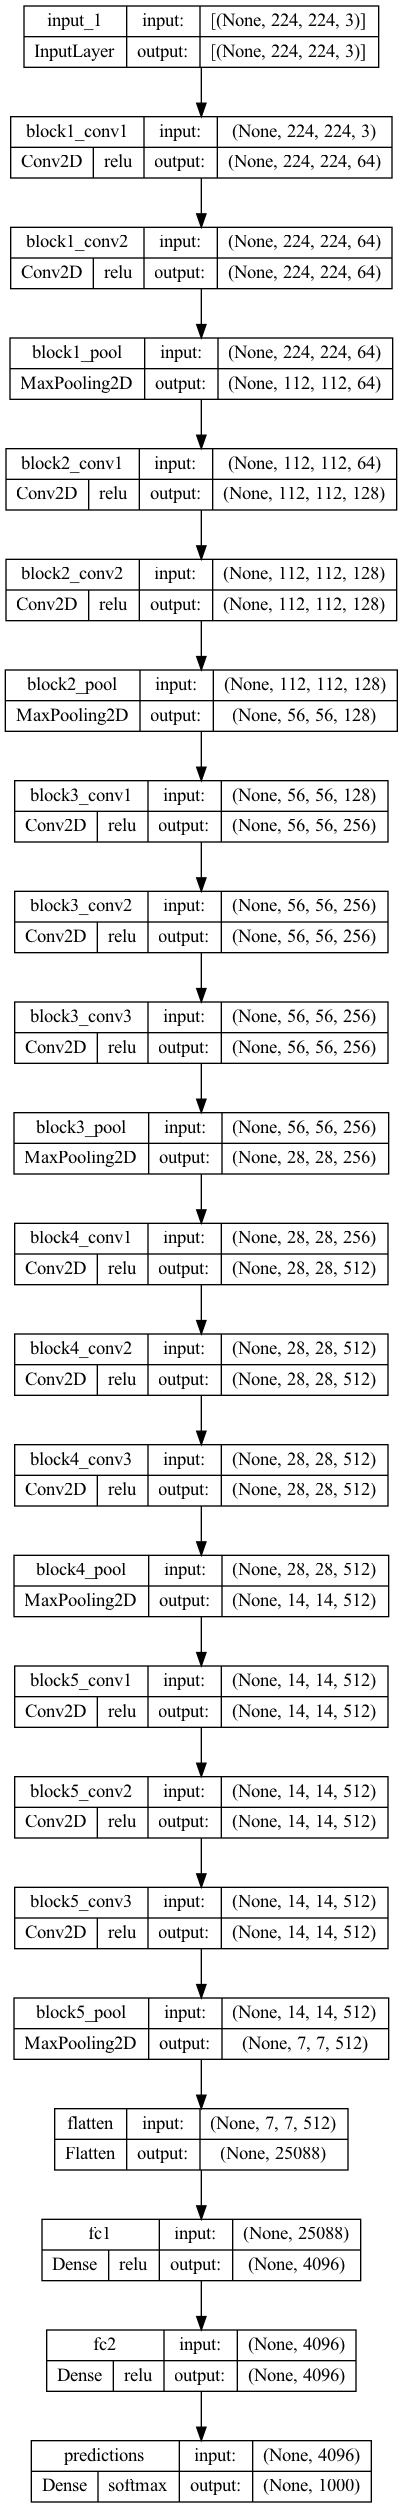

In [3]:
plot_model(model,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
# Load and preprocess the image
img_path = 'Group_20/train/butterfly/image_0001.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Get the activations for the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, np.argmax(predictions[0])]
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Identify the neuron with the maximum activation value
activations = conv_outputs[0]
# t3 = 0
# for i in range(activations.shape[-1]):
#     t1 = activations[:, :, i]
#     t2 = pooled_grads[i]
#     activations[:, :, i] *= pooled_grads[i]

heatmap = np.mean(activations, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Use Grad-CAM to get the patch in the image that caused the neuron to fire
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
cv2.imshow('image', superimposed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
